使用增强型WGAN生成Cifar10数据
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/Cat64/"
EPOCH = 100
BATCH_SIZE = 64
NOISE_DIM = 100
IMAGE_CHANNEL = 3
IMAGE_SIZE = 64
LAMBDA = 0.25
LEARNING_RATE = 5e-5

In [2]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
        elif isinstance(m, torch.nn.BatchNorm2d):
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

# 2.模型

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(NOISE_DIM, 64 * 16, 4, 1, 0, bias=False),
            torch.nn.SELU(inplace=True)
        )
        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 16, 64 * 8, 4, 2, 1, bias=False),
            torch.nn.SELU(inplace=True)
        )
        self.deconv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            torch.nn.SELU(inplace=True)
        )
        self.deconv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            torch.nn.SELU(inplace=True)
        )
        self.deconv5 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 2, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

        initialize_weights(self)

    def forward(self, x):
        output = self.deconv1(x)
        output = self.deconv2(output)
        output = self.deconv3(output)
        output = self.deconv4(output)
        output = self.deconv5(output)
        return output


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 64 * 2, 4, 2, 1, bias=False),
            torch.nn.SELU(inplace=True)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            torch.nn.SELU(inplace=True)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            torch.nn.SELU(inplace=True)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 8, 64 * 16, 4, 2, 1, bias=False),
            torch.nn.SELU(inplace=True)
        )

        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 16, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )
        initialize_weights(self)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = output.view(-1)

        return output

# 3.导入数据

In [4]:
NetD = Discriminator()
NetG = Generator()
optimizerD = torch.optim.Adam(NetD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(NetG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

dataset = tv.datasets.ImageFolder(root=DATA_PATH, transform=tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([0.5] * 3, [0.5] * 3)
]))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

x            = torch.FloatTensor(BATCH_SIZE, IMAGE_CHANNEL, IMAGE_SIZE, IMAGE_SIZE)
x_both       = torch.FloatTensor(BATCH_SIZE, IMAGE_CHANNEL, IMAGE_SIZE, IMAGE_SIZE)
z            = torch.FloatTensor(BATCH_SIZE, NOISE_DIM, 1, 1)
u            = torch.FloatTensor(BATCH_SIZE, 1, 1, 1)
z_test       = torch.FloatTensor(100, NOISE_DIM, 1, 1).normal_(0, 1)
grad_outputs = torch.ones(BATCH_SIZE)
one          = torch.FloatTensor([1])
one_neg      = one * -1

x_var      = torch.autograd.Variable(x)
z_var      = torch.autograd.Variable(z)
z_test_var = torch.autograd.Variable(z_test)


if torch.cuda.is_available() > 0:
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    x_var = x_var.cuda()
    z_var = z_var.cuda()
    u = u.cuda()
    z_test_var = z_test_var.cuda()
    grad_outputs = grad_outputs.cuda()
    one, one_neg = one.cuda(), one_neg.cuda()

# 4.训练

In [5]:
showbar = bar.ProgressBar(EPOCH, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCH + 1):
    for index, (image, label) in enumerate(train_loader):
        mini_batch = image.shape[0]
        for p in NetD.parameters():
            p.requires_grad = True

        real_var = torch.autograd.Variable(image)

        if torch.cuda.is_available():
            real_var = real_var.cuda()

        optimizerD.zero_grad()

        D_real = NetD(real_var)
        D_real_loss = D_real.mean()
        D_real_loss.backward(one_neg)

        z_var.data.normal_(0, 1)
        z_volatile = torch.autograd.Variable(z_var.data, volatile = True)
        x_fake = torch.autograd.Variable(NetG(z_volatile).data)
        # Discriminator Loss fake
        D_fake_loss = NetD(x_fake)
        D_fake_loss = D_fake_loss.mean()
        D_fake_loss.backward(one)

        u.uniform_(0, 1)
        x_both = x_var.data*u + x_fake.data*(1-u)
        if torch.cuda.is_available():
            x_both = x_both.cuda()

        x_both = torch.autograd.Variable(x_both, requires_grad=True)
        grad = torch.autograd.grad(outputs=NetD(x_both), inputs=x_both, grad_outputs=grad_outputs, retain_graph=True,
                                   create_graph=True, only_inputs=True)[0]
        grad_penalty = 10*((grad.norm(2, 1).norm(2, 1).norm(2, 1) - 1) ** 2).mean()
        grad_penalty.backward()
        # Optimize
        errD_penalty = D_fake_loss - D_real_loss + grad_penalty
        D_loss = D_fake_loss - D_real_loss
        optimizerD.step()

        G_loss = D_loss
        if ((index+1) % 5) == 0:
            for p in NetD.parameters():
                p.requires_grad = False
            # update G network
            optimizerG.zero_grad()

            z_var.data.normal_(0, 1)
            x_fake = NetG(z_var)
            # Generator Loss
            errG = NetD(x_fake)
            errG = errG.mean()
            # print(errG)
            errG.backward(one_neg)
            optimizerG.step()

        showbar.show(epoch, D_loss.item(), G_loss.item())

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch:1 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.530;G Loss:-0.530,total=0:01:570
Epoch:2 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.521;G Loss:-0.521,total=0:01:560
Epoch:3 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.539;G Loss:-0.539,total=0:01:560
Epoch:4 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.574;G Loss:-0.574,total=0:01:560
Epoch:5 / 100 [*********************************************************************************************************************

Epoch:37 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.265;G Loss:-0.265,total=0:01:55020:1996
Epoch:38 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.150;G Loss:-0.150,total=0:01:56005:4000
Epoch:39 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.235;G Loss:-0.235,total=0:01:56033:2880
Epoch:40 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.291;G Loss:-0.291,total=0:01:55012:1053
Epoch:41 / 100 [************************************************************************************

Epoch:73 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.127;G Loss:-0.127,total=0:01:550:06:163
Epoch:74 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.234;G Loss:-0.234,total=0:01:550:14:588
Epoch:75 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.065;G Loss:-0.065,total=0:01:550:34:5277
Epoch:76 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:-0.335;G Loss:-0.335,total=0:01:550:54:4221
Epoch:77 / 100 [**********************************************************************************

# 5.生成数据

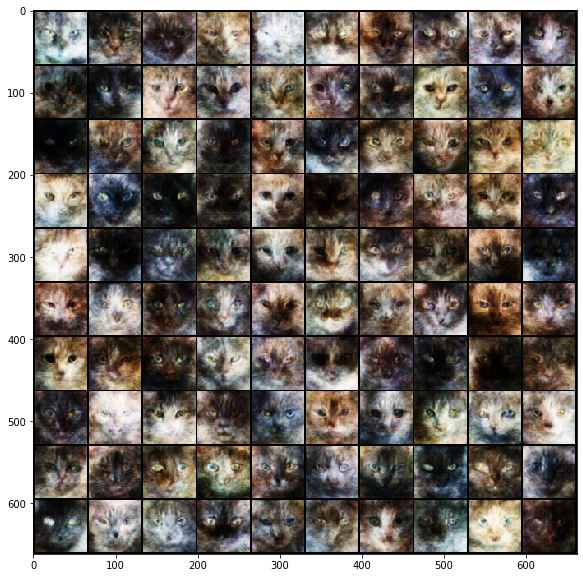

In [6]:
fake_u=NetG(z_test_var)
img = tv.utils.make_grid(fake_u.data[:100], nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))